[Why is it better to use np.linalg.solve() than np.linalg.inv()](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li)

# Question 1

In [1]:
import numpy as np
data = np.load('ct_data.npz')
X_train = data['X_train']; X_val = data['X_val']; X_test = data['X_test']
y_train = data['y_train']; y_val = data['y_val']; y_test = data['y_test']

In [2]:
print(f"Mean of training positions is {np.mean(y_train)}")
print(f"Mean of validation labels = {np.mean(y_val)}, standard error = {np.std(y_val) / np.sqrt(len(y_val))}")
print(f"Mean of first 5785 training labels = {np.mean(y_train[:5785])}, standard error = {np.std(y_train[:5785]) / np.sqrt(5785)}")

Mean of training positions is -9.13868774539957e-15
Mean of validation labels = -0.2160085093241599, standard error = 0.012903383410668334
Mean of first 5785 training labels = -0.44247687859693674, standard error = 0.01192627246273395


In [3]:
print(np.shape(X_train))
print(np.shape(y_train))

print(np.max(y_train))
print(np.min(y_train))

(40754, 384)
(40754,)
2.2265180851800834
-1.8679386519531087


In [4]:
idx_train = np.min(X_train, axis=0) != np.max(X_train, axis=0)

print("Columns dropped from data in first stage:")
print(np.where(np.logical_not(idx_train))[0])

X_train = X_train[: , idx_train]
X_val = X_val[: , idx_train]
X_test = X_test[: , idx_train]

_, idx_train = np.unique(X_train, axis=1, return_index=True)

print("Columns dropped from data in second stage:")
print(np.setdiff1d(np.arange(X_train.shape[1]), idx_train))

idx_train.sort()

X_train = X_train[:, idx_train]
X_val = X_val[:, idx_train]
X_test = X_test[:, idx_train]

Columns dropped from data in first stage:
[ 59  69 179 189 351]
Columns dropped from data in second stage:
[ 76  77 185 195 283 354]


In [5]:
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))

(40754, 373)
(5785, 373)
(6961, 373)


# Question 2

In [6]:
def fit_linreg(X, yy, alpha):
    """Regularized least squares for a linear fit.

    Inputs:
         X: N,D design matrix of input features
        yy: N,  real-valued targets
     alpha: regularization constant

    Outputs: w Least-squares solution of the weights
    """
    # Augment the data by adding bias term
    k = X.shape[1] # Number of features (columns)
    I_k = np.sqrt(alpha) * np.eye(k)
    zero_k = np.zeros(k)
    X_reg = np.vstack((X, I_k))
    y_reg = np.hstack((yy, zero_k))
    X_bias = np.concatenate([X_reg, np.ones((X_reg.shape[0], 1))], axis=1)
    return np.linalg.lstsq(X_bias, y_reg, rcond=None)[0]

def rmse(true_values, predicted_values):
    """
    Returns the root mean squared error between two arrays.
    """
    residuals = true_values - predicted_values
    
    return np.sqrt(np.mean(residuals**2))

# Our linear regression
w_fit = fit_linreg(X_train, y_train, alpha=30)

X_bias_train = np.concatenate([X_train, np.ones((X_train.shape[0], 1))], axis=1)
y_predicted_linreg_train = X_bias_train@w_fit
linreg_rmse_train = rmse(y_train, y_predicted_linreg_train)
print(f"RMSE of least squares linear regression model evaluated on training data is: {linreg_rmse_train}")

X_bias_val = np.concatenate([X_val, np.ones((X_val.shape[0], 1))], axis=1)
y_predicted_linreg_val = X_bias_val@w_fit
linreg_rmse_val = rmse(y_val, y_predicted_linreg_val)
print(f"RMSE of least squares linear regression model evaluated on validation data is: {linreg_rmse_val}")

RMSE of least squares linear regression model evaluated on training data is: 0.35678408517295845
RMSE of least squares linear regression model evaluated on validation data is: 0.42287979780683593


In [7]:
# Linear regression with gradient descent
from ct_support_code import *

w_fit_gradopt, b_fit_gradopt = fit_linreg_gradopt(X_train, y_train, alpha=30)

y_predicted_linreg_gradopt_train = X_train@w_fit_gradopt + b_fit_gradopt
linreg_gradopt_rmse_train = rmse(y_train, y_predicted_linreg_gradopt_train)
print(f"RMSE of gradient descent linear regression model evaluated on training data is: {linreg_gradopt_rmse_train}")

y_predicted_linreg_gradopt_val = X_val@w_fit_gradopt + b_fit_gradopt
linreg_gradopt_rmse_val = rmse(y_val, y_predicted_linreg_gradopt_val)
print(f"RMSE of gradient descent linear regression model evaluated on validation data is: {linreg_gradopt_rmse_val}")

RMSE of gradient descent linear regression model evaluated on training data is: 0.3567552912135179
RMSE of gradient descent linear regression model evaluated on validation data is: 0.4230626605868067


# Question 3 Mod

In [8]:
K = 20 # number of thresholded classification problems to fit
mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)

D = X_train.shape[1]
alpha = 30
V_linlogreg = np.zeros((K,D))
bk_linlogreg = np.zeros(K)

for kk in range(K):
    labels = y_train > thresholds[kk]
    
    # ... fit logistic regression to these labels    
    args = (X_train, labels, alpha)
    init = (np.zeros(D), np.array(0))
    v, b = minimize_list(logreg_cost, init, args)
    
    V_linlogreg[kk,:] = v
    bk_linlogreg[kk] = b

In [9]:
def sigmoid(a):
    return(1/(1+np.exp(-a)))

logistic_classified_train = sigmoid(X_train@V_linlogreg.T + bk_linlogreg)
logistic_classified_val = sigmoid(X_val@V_linlogreg.T+ bk_linlogreg)

w_fit_linlogreg = fit_linreg(logistic_classified_train, y_train, alpha=30)

X_bias_linlogreg_train = np.concatenate([logistic_classified_train, np.ones((logistic_classified_train.shape[0], 1))], axis=1)
y_predicted_linlogreg_train = X_bias_linlogreg_train@w_fit_linlogreg
linlogreg_rmse_train = rmse(y_train, y_predicted_linlogreg_train)
print(f"RMSE of combined logistic and linear regression model evaluated on training data is: {linlogreg_rmse_train}")

X_bias_linlogreg_val = np.concatenate([logistic_classified_val, np.ones((logistic_classified_val.shape[0], 1))], axis=1)
y_predicted_linlogreg_val = X_bias_linlogreg_val@w_fit_linlogreg
linlogreg_rmse_val = rmse(y_val, y_predicted_linlogreg_val)
print(f"RMSE of combined logistic and linear regression model evaluated on validation data is: {linlogreg_rmse_val}")

RMSE of combined logistic and linear regression model evaluated on training data is: 0.15418231905235819
RMSE of combined logistic and linear regression model evaluated on validation data is: 0.25438421013596463


# Question 4

### Sensible random initial parameters 

As our input features are around 1 we can use 0.1*randn/sqrt(M), where M are the number of values in the weight matrix.

In [10]:
K = 20
D = X_train.shape[1]
alpha = 30

random_seed = 44
rstate  = np.random.default_rng(random_seed)

# USING RANDOM INITIALIZATION OF PARAMETERS
# We initialize the weights as described by Glorot and Bengio in their paper
# “Understanding the difficulty of training deep feedforward networks”,
# AISTATS, 2010. (From Lecture 6 of MLP slides)
ww = rstate.normal(size=(K)) * np.sqrt(2/(K+1))
bb = 0
V  = rstate.normal(size=(K,D)) * np.sqrt(2/(D+K))
bk = np.zeros(K)

args = (X_train, y_train, alpha)
init = (ww, bb, V, bk)

ww, bb, V, bk = minimize_list(nn_cost, init, args)

In [11]:
y_predicted_nn_train = sigmoid(X_train@V.T + bk)@ww + bb
rmse_nn_train_q4 = rmse(y_train, y_predicted_nn_train)
print(f"RMSE of neural network initialized with random parameters evaluated on training data is: {rmse_nn_train_q4}")

y_predicted_nn_val = sigmoid(X_val@V.T + bk)@ww + bb
rmse_nn_val_q4 = rmse(y_val, y_predicted_nn_val)
print(f"RMSE of neural network initialized with random parameters evaluated on validation data is: {rmse_nn_val_q4}")

RMSE of neural network initialized with random parameters evaluated on training data is: 0.14011511053217043
RMSE of neural network initialized with random parameters evaluated on validation data is: 0.2706117197471353


### Using parameters from Q3 

In [12]:
# INITIALIZING USING PARAMETERS FROM Q3
ww_linlogreg = w_fit_linlogreg[:-1]
bb_linlogreg = w_fit_linlogreg[-1]

args = (X_train, y_train, alpha)
init = (ww_linlogreg, bb_linlogreg, V_linlogreg, bk_linlogreg)

ww, bb, V, bk = minimize_list(nn_cost, init, args)

In [13]:
y_predicted_nn_train = sigmoid(X_train@V.T + bk)@ww + bb
rmse_nn_train = rmse(y_train, y_predicted_nn_train)
print(f"RMSE of neural network initialized with the parameters from Q3 evaluated on training data is: {rmse_nn_train}")

y_predicted_nn_val = sigmoid(X_val@V.T + bk)@ww + bb
rmse_nn_val = rmse(y_val, y_predicted_nn_val)
print(f"RMSE of neural network initialized with the parameters from Q3 evaluated on validation data is: {rmse_nn_val}")

RMSE of neural network initialized with the parameters from Q3 evaluated on training data is: 0.13974507667481212
RMSE of neural network initialized with the parameters from Q3 evaluated on validation data is: 0.2705490561706224


Random initialization seems to work better than starting from known values.

# Question 5

In [14]:
K = 20
D = X_train.shape[1]

def train_nn_reg(alpha):
    """Trains the neural network from Q4 for a given alpha parameter
    and returns RMSE on the validation and test set. The reason for
    also outputting the test set RMSE is because we are asked to 
    report it afterwards

    Inputs:
     alpha: regularization constant

    Outputs: RMSE on the validation and test set
    """
    random_seed = 44
    rstate  = np.random.default_rng(random_seed)

    ww = rstate.normal(size=(K)) * np.sqrt(2/(K+1))
    bb = 0
    V  = rstate.normal(size=(K,D)) * np.sqrt(2/(D+K))
    bk = np.zeros(K)

    args = (X_train, y_train, alpha)
    init = (ww, bb, V, bk)

    ww, bb, V, bk = minimize_list(nn_cost, init, args)
    
    # We now calculate the RMSE for the validation data.
    y_predicted_nn_val = sigmoid(X_val@V.T + bk)@ww + bb
    rmse_nn_val = rmse(y_val, y_predicted_nn_val)
    
    # We now calculate the RMSE for the test data.
    y_predicted_nn_test = sigmoid(X_test@V.T + bk)@ww + bb
    rmse_nn_test = rmse(y_test, y_predicted_nn_test)
    
    return rmse_nn_val, rmse_nn_test

In [15]:
alpha_rest = list(np.arange(0,50.02,0.02))
alpha_obs = [12.5, 25 ,37.5]  #equidistant values
yy = []

mlog_rmse_nn_val_baseline = -np.log(rmse_nn_val_q4)

for alpha in alpha_obs:
    # Remove measured alpha from test alpha
    alpha_rest.remove(alpha)
    
    rmse_nn_val_alpha_obs, _ = train_nn_reg(alpha)
    mlog_rmse_nn_val_alpha_obs = -np.log(rmse_nn_val_alpha_obs)
    yy.append(mlog_rmse_nn_val_alpha_obs - mlog_rmse_nn_val_baseline)

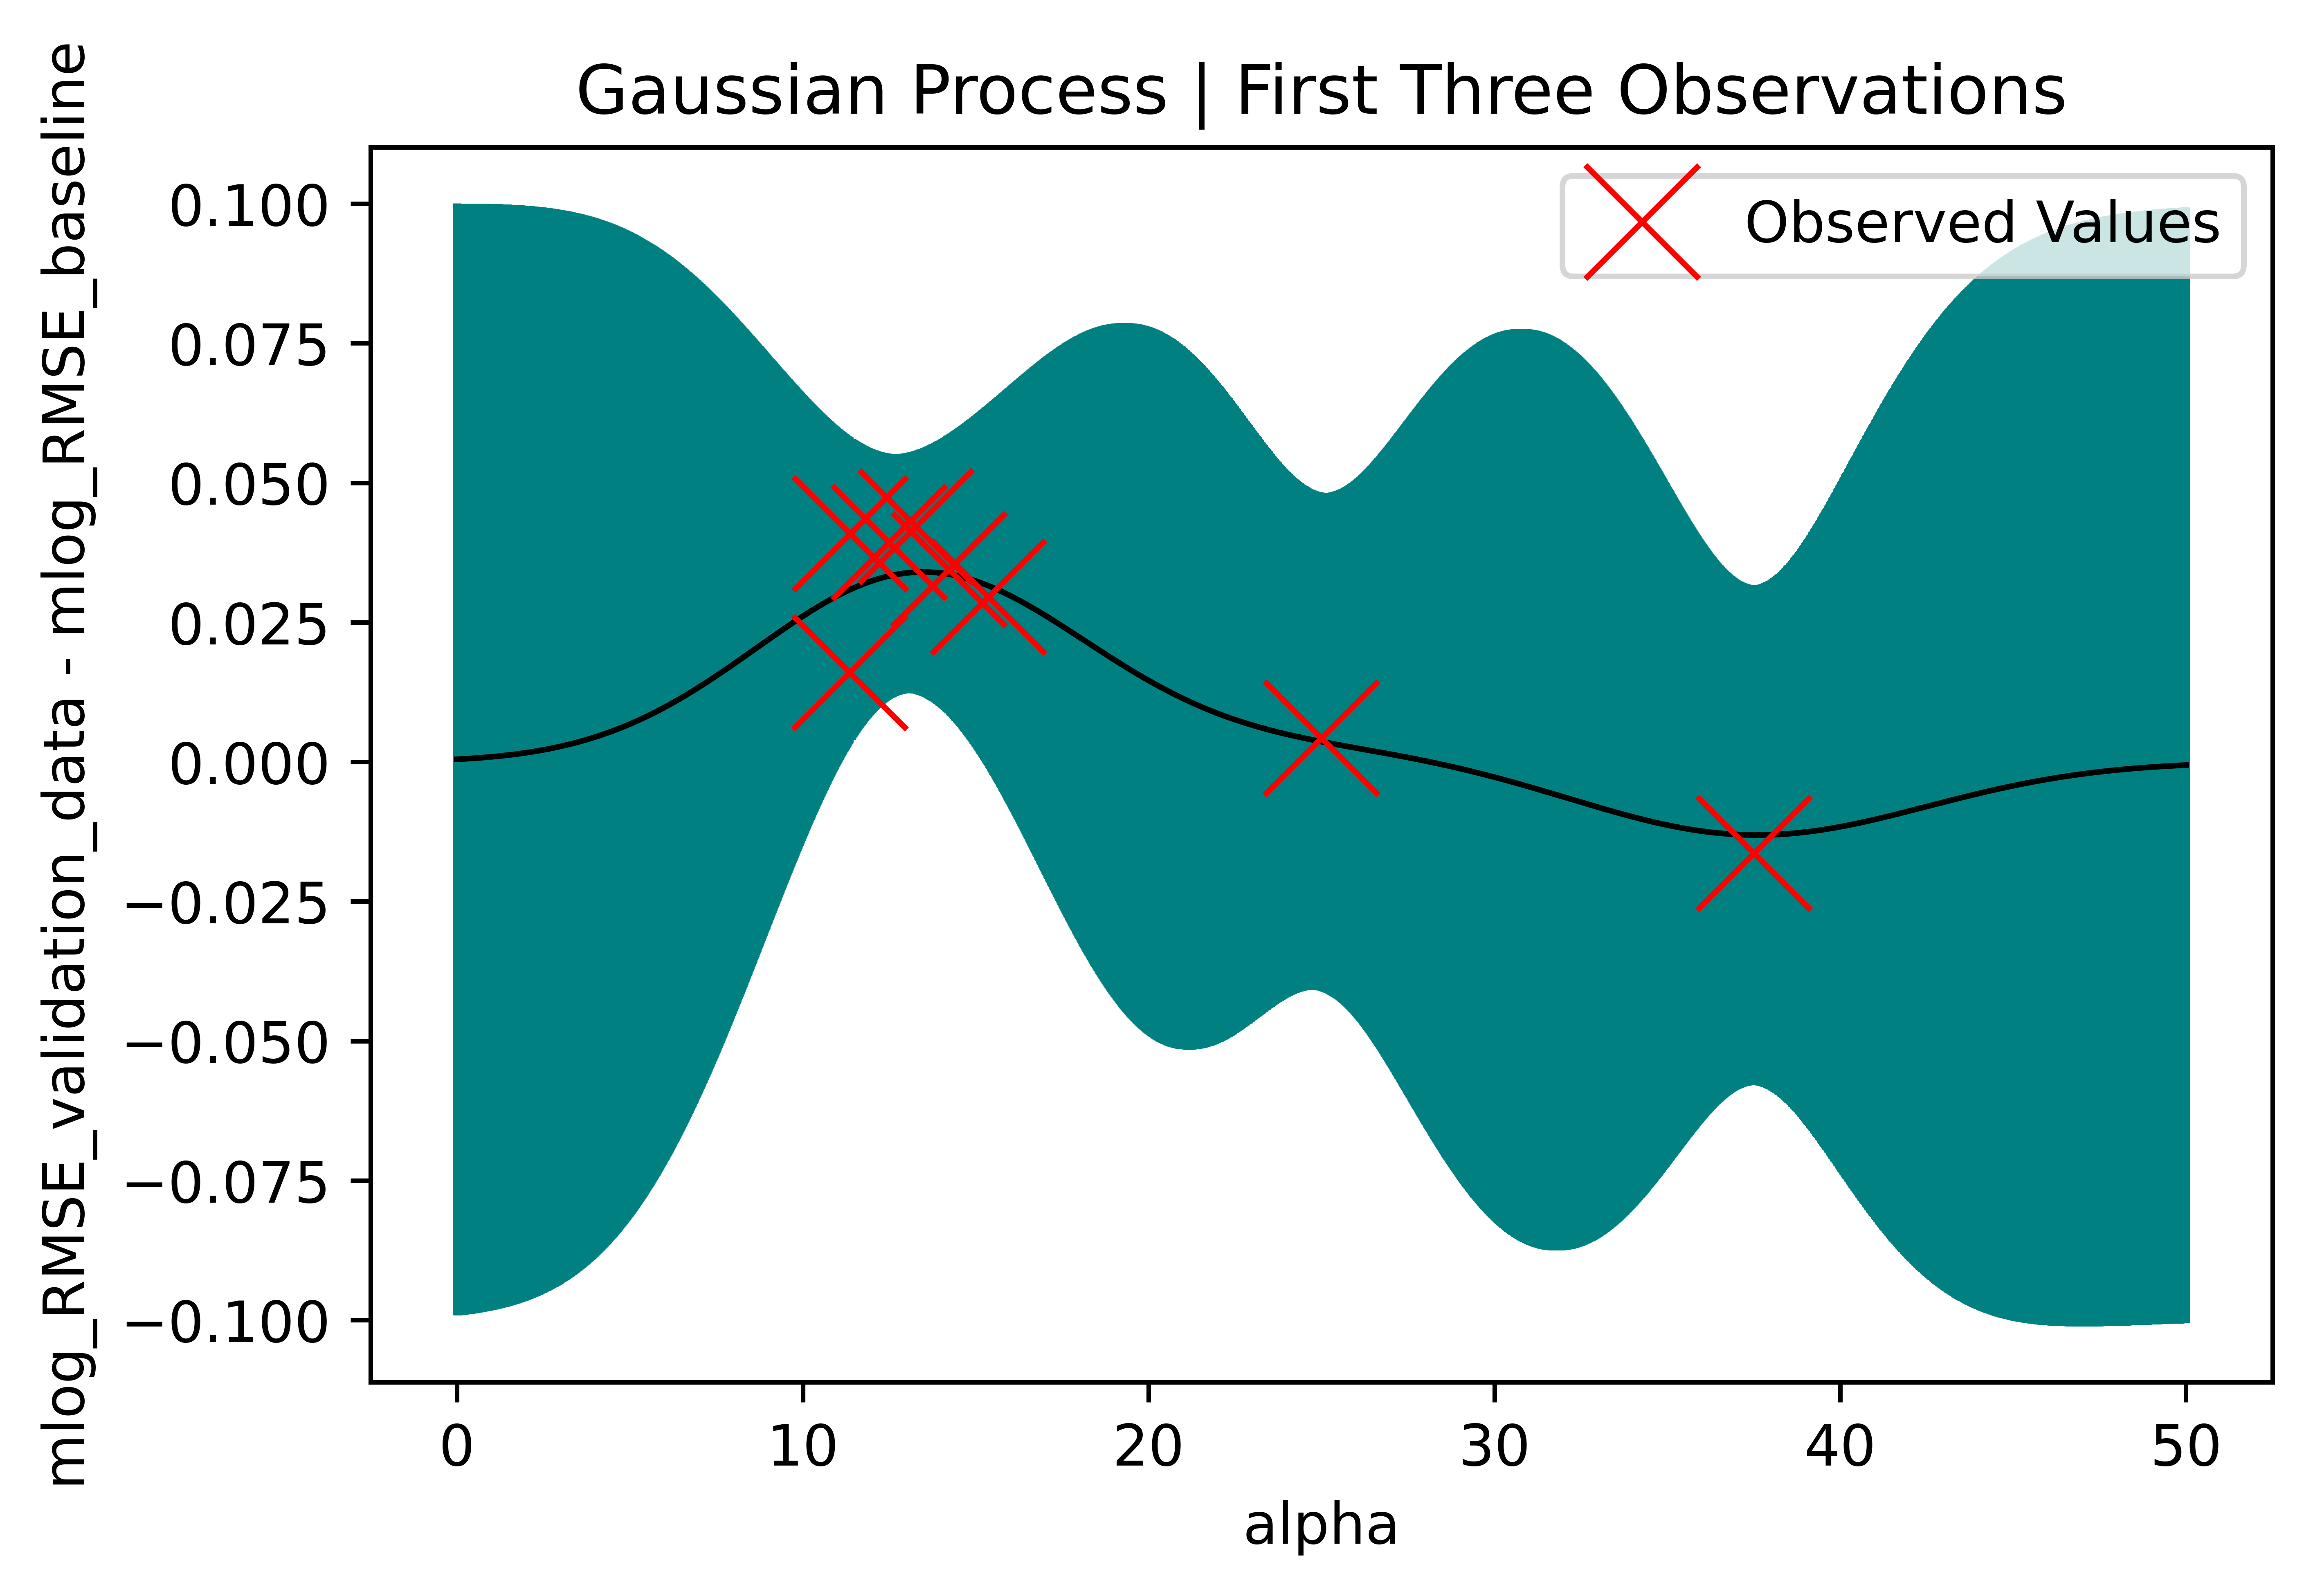

In [27]:
# As asked for in the question, we calculate Gaussian process posterior for the first three observations.
# We also graphically present this result in a plot.
rest_cond_mu, rest_cond_cov = gp_post_par(np.array(alpha_rest), np.array(alpha_obs), np.array(yy))

import matplotlib.pyplot as plt

plt.figure(dpi=1000)
plt.errorbar(alpha_rest, rest_cond_mu, yerr=np.sqrt(np.diag(rest_cond_cov)), fmt='None', color='teal')
plt.plot(alpha_rest, rest_cond_mu, color='black', linewidth=1)
plt.plot(alpha_obs, yy, 'rx', markersize=20, label='Observed Values')
plt.xlabel("alpha")
plt.ylabel("mlog_RMSE_validation_data - mlog_RMSE_baseline")
plt.title("Gaussian Process | First Three Observations")
plt.legend()
plt.show()

In [17]:
# WE NOW DEFINE ACQUISITION FUNCTION
from scipy.stats import norm

def acquisition_function(alpha_rest, alpha_obs, yy):
    """Probability of Improvement function

     For a set of given observed values of -log(RMSE_validation_data), calculates
     which regularization parameter alpha we should measure next in order to
     maximise our chances of reducing our error. 

     Inputs:
             alpha_rest GP test locations
              alpha_obs locations of observations
                     yy observed values
                     
     Outputs:
           best_alpha  Alpha to measure for the highest probability of improvement
           best_PI     Probability of improvement of given alpha
    """
    # From observed alphas, obtain the one which gives the best y val. 
    best_mlog_rmse_alpha_obs = -1E6
    for y in yy:
        mlog_rmse_alpha_obs = y
        
        if mlog_rmse_alpha_obs > best_mlog_rmse_alpha_obs:
            best_mlog_rmse_alpha_obs = mlog_rmse_alpha_obs

    # Calculate the Gaussian process posterior
    rest_cond_mu, rest_cond_cov = gp_post_par(np.array(alpha_rest), np.array(alpha_obs), np.array(yy))
    rest_stdev = np.sqrt(np.diag(rest_cond_cov))
    
    # We now try to find the alpha that gives the biggest probability for improvement
    best_alpha = 0
    best_PI = 0
    
    for alpha, mu, stdev in zip(alpha_rest, rest_cond_mu, rest_stdev):
        test_PI = norm.cdf((mu-best_mlog_rmse_alpha_obs)/stdev)
        
        if test_PI > best_PI:
            best_alpha = alpha
            best_PI = test_PI
            
    return best_alpha, best_PI

In [18]:
rmse_nn_val_alpha_obs_list = []
rmse_nn_test_alpha_obs_list = []
best_PI_list = []

# We iteratively pick new alphas, retrain and evaluate each new model with
# train_nn_reg and update the posterior with gp_post_par.
for i in range(5):
    best_alpha, best_PI = acquisition_function(alpha_rest, alpha_obs, yy)
    best_PI_list.append(best_PI)
    
    # We add the alpha we are going to observe to our observed list "alpha_obs"
    # and remove it from our GP test locations "alpha_rest".
    alpha_rest.remove(best_alpha)
    alpha_obs.append(best_alpha)
    
    rmse_nn_val_alpha_obs, rmse_nn_test_alpha_obs = train_nn_reg(best_alpha)
    mlog_rmse_nn_val_alpha_obs = -np.log(rmse_nn_val_alpha_obs)
    yy.append(mlog_rmse_nn_val_alpha_obs - mlog_rmse_nn_val_baseline)
    
    rmse_nn_val_alpha_obs_list.append(rmse_nn_val_alpha_obs)
    rmse_nn_test_alpha_obs_list.append(rmse_nn_test_alpha_obs)

In [19]:
for i in range(5):
    print(f"Iteration {i+1}")
    print(f"Best Alpha: {alpha_obs[-5+i]}")
    print(f"Probability of Improvement: {best_PI_list[i]}")
    print(f"Validation set RMSE: {rmse_nn_val_alpha_obs_list[i]}")
    print(f"Test set RMSE {rmse_nn_test_alpha_obs_list[i]}")
    print("")

Iteration 1
Best Alpha: 13.280000000000001
Probability of Improvement: 0.4307143236546995
Validation set RMSE: 0.25944624500308694
Test set RMSE 0.28751810969184527

Iteration 2
Best Alpha: 14.24
Probability of Improvement: 0.4340838010908416
Validation set RMSE: 0.26145670989978714
Test set RMSE 0.2910958451342825

Iteration 3
Best Alpha: 11.38
Probability of Improvement: 0.42718345634811933
Validation set RMSE: 0.2597989372514801
Test set RMSE 0.28681788714240586

Iteration 4
Best Alpha: 11.36
Probability of Improvement: 0.4374995652464331
Validation set RMSE: 0.26633171119124394
Test set RMSE 0.2898598123382185

Iteration 5
Best Alpha: 15.38
Probability of Improvement: 0.4143148735383487
Validation set RMSE: 0.2627314455249624
Test set RMSE 0.29074547267149375



# Question 6

In [20]:
def preprocess_yvals(y, K):
    """
    Takes real-valued y outputs and classifies them into K different categories. 
    It then one-hot encodes them.
    """
    # Defines K number of thresholded classification problems to fit
    mx = np.max(y); mn = np.min(y); hh = (mx-mn)/K
    thresholds = np.arange(mn+hh, mx, hh)
    idx = np.searchsorted(thresholds, y)
    
    # One hot encodes the y values into K categories.
    y_one_hot_encoded = np.zeros((len(y),K))
    y_one_hot_encoded[np.arange(len(y)), idx] = 1

    return y_one_hot_encoded   

In [21]:
def softmax_cost(params, X, yy=None, alpha=None):
    """Regularized softmax regression cost function and gradients

    Can be optimized with minimize_list. The second parameter 0 is there so 
    that the tuple params can be properly unwrapped according to the provided
    helper functions like params_wrap.

    Inputs:
    params: tuple (W, 0): weights W (K,D)
         X: N,D design matrix of input features
        yy: N,K One-hot encoded targets
     alpha: regularization constant

    Outputs: (E, [W_bar, 0]), cost and gradients
    """
    # Unpack parameters from list
    W = params[0]  # K,D
    
    # Forward computation of cost.
    matrix_sk = np.exp(X@W.T)
    matrix_sum_of_sk = np.vstack(np.sum(matrix_sk, axis=1))
    
    # Every row of F contains f_k = s_k/sum(s_k) for a particular input x.
    F = matrix_sk/matrix_sum_of_sk   # N,K
    
    if yy is None:
        # User wants prediction rather than training signal
        return F
    
    # For every training input picks f_k where yy is 1.
    yc = np.argmax(yy, axis=1)
    fc_picked_for_every_input = F[np.arange(np.shape(yy)[0]), yc]
    
    E = -np.sum(np.log(fc_picked_for_every_input)) + alpha*(np.sum(W*W)) # 1x1

    # Reverse computation of gradients
    W_bar = (F-yy).T @ X + 2*alpha*W
    
    return E, (W_bar,0)

In [22]:
alpha_softmax = 60
K = 15
D = X_train.shape[1]

random_seed = 44
rstate  = np.random.default_rng(random_seed)

W  = rstate.normal(size=(K,D)) * np.sqrt(2/(D+K))

args = (X_train, preprocess_yvals(y_train, K), alpha_softmax)
init = (W,0)

W = minimize_list(softmax_cost, init, args)[0]

In [23]:
softmax_classified_train = softmax_cost((W,0), X_train)
softmax_classified_val = softmax_cost((W,0), X_val)
softmax_classified_test = softmax_cost((W,0), X_test)

w_fit_softmax = fit_linreg(softmax_classified_train, y_train, alpha=30)

X_bias_softmax_train = np.concatenate([softmax_classified_train, np.ones((softmax_classified_train.shape[0], 1))], axis=1)
y_predicted_softmax_train = X_bias_softmax_train@w_fit_softmax
softmax_rmse_train = rmse(y_train, y_predicted_softmax_train)
print(f"RMSE of combined softmax and linear regression evaluated on training data is: {softmax_rmse_train}")

X_bias_softmax_val = np.concatenate([softmax_classified_val, np.ones((softmax_classified_val.shape[0], 1))], axis=1)
y_predicted_softmax_val = X_bias_softmax_val@w_fit_softmax
softmax_rmse_val = rmse(y_val, y_predicted_softmax_val)
print(f"RMSE of combined softmax and linear regression evaluated on validation data is: {softmax_rmse_val}")

X_bias_softmax_test = np.concatenate([softmax_classified_test, np.ones((softmax_classified_test.shape[0], 1))], axis=1)
y_predicted_softmax_test = X_bias_softmax_test@w_fit_softmax
softmax_rmse_test = rmse(y_test, y_predicted_softmax_test)
print(f"RMSE of combined softmax and linear regression evaluated on test data is: {softmax_rmse_test}")

RMSE of combined softmax and linear regression evaluated on training data is: 0.1508400831862094
RMSE of combined softmax and linear regression evaluated on validation data is: 0.22658355135217065
RMSE of combined softmax and linear regression evaluated on test data is: 0.23663471274096906


In [24]:
print(softmax_classified_train[0,:])

[1.03759747e-03 1.92855541e-02 9.69243949e-01 3.69422306e-03
 8.78385643e-04 9.95677632e-06 1.04136305e-04 1.24566232e-03
 4.68937046e-04 2.67568241e-03 5.52478153e-04 7.44220707e-04
 3.89413575e-05 6.25100243e-06 1.40251996e-05]


In [25]:
print(softmax_classified_train[0,:]) # low alpha

[1.03759747e-03 1.92855541e-02 9.69243949e-01 3.69422306e-03
 8.78385643e-04 9.95677632e-06 1.04136305e-04 1.24566232e-03
 4.68937046e-04 2.67568241e-03 5.52478153e-04 7.44220707e-04
 3.89413575e-05 6.25100243e-06 1.40251996e-05]


In [26]:
print(norm.cdf(0))

0.5
